In [33]:
!pip install conllu
!pip install torchtext

In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import conllu
from torchtext.vocab import GloVe
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset , DataLoader
# from torchtext.vocab import build_vocab_from_iterator, Vocab
from torch.nn.utils.rnn import pad_sequence , pack_padded_sequence, pad_packed_sequence
import torch.optim as optim

torch.manual_seed(42)

In [35]:
##------------------ Global Variable -----------------------------------------------------
start_tag = '<S>'
end_tag = '</S>'
unknown_token = '<UKN>'
padding_token = '<PAD>'

BATCH_SIZE = 64
round_precision = 5
EPOCHS = 10
embedding_dim = 200
hidden_layer_dim = 200
learning_rate = 1e-3
epochs = 10
bidirectional = True
num_layer = 2

# glove_file_path = '/content/glove.6B.100d.txt'

unknown_word_embedding = np.zeros(embedding_dim)
start_tag_embedding = np.round(np.random.normal(size=(embedding_dim,)) , round_precision)
end_tag_embedding = np.round(np.random.normal(size=(embedding_dim)) , round_precision)

In [36]:
device = "cuda" if torch.cuda.is_available() else "cpu"


In [37]:
file = open('/content/en_atis-ud-train.conllu' , 'r')
train = file.read()
file.close()

file = open('/content/en_atis-ud-dev.conllu', 'r')
val = file.read()
file.close()

file = open('/content/en_atis-ud-test.conllu', 'r')
test = file.read()
file.close()

In [38]:
train

"# sent_id = 0001.train\n# text = what is the cost of a round trip flight from pittsburgh to atlanta beginning on april twenty fifth and returning on may sixth\n1\twhat\twhat\tPRON\t_\tPronType=Int,Rel\t0\troot\t_\t_\n2\tis\tbe\tAUX\t_\tMood=Ind|Number=Sing|Person=3|Tense=Pres|VerbForm=Fin\t1\tcop\t_\t_\n3\tthe\tthe\tDET\t_\tPronType=Art\t4\tdet\t_\t_\n4\tcost\tcost\tNOUN\t_\tNumber=Sing\t1\tnsubj\t_\t_\n5\tof\tof\tADP\t_\t_\t7\tcase\t_\t_\n6\ta\ta\tDET\t_\tPronType=Art\t7\tdet\t_\t_\n7\tround\tround\tNOUN\t_\tNumber=Sing\t4\tnmod\t_\t_\n8\ttrip\ttrip\tNOUN\t_\tNumber=Sing\t7\tcompound\t_\t_\n9\tflight\tflight\tNOUN\t_\tNumber=Sing\t7\tnmod\t_\t_\n10\tfrom\tfrom\tADP\t_\t_\t11\tcase\t_\t_\n11\tpittsburgh\tPittsburgh\tPROPN\t_\tNumber=Sing\t9\tnmod\t_\t_\n12\tto\tto\tADP\t_\t_\t13\tcase\t_\t_\n13\tatlanta\tAtlanta\tPROPN\t_\tNumber=Sing\t9\tnmod\t_\t_\n14\tbeginning\tbegin\tVERB\t_\tTense=Pres|VerbForm=Part\t9\tnmod\t_\t_\n15\ton\ton\tADP\t_\t_\t16\tcase\t_\t_\n16\tapril\tApril\tNOUN\t_

In [39]:
def preprocssing(data):

  sentences = []   # return structure

  currrent_sentence = []
  sentence_token = []
  token_pos = []

  pos_tags = set()
  word_freq = dict()

  lines = data.strip().split('\n')

  for line in lines:

    if(len(line) < 1):
      currrent_sentence.append(sentence_token)
      currrent_sentence.append(token_pos)
      sentences.append(currrent_sentence)

      sentence_token = []
      token_pos = []
      currrent_sentence = []

    elif line.startswith('# sent_id'):
      continue

    elif line.startswith('# text ='):
      continue

    else:
      tokens =line.split('\t')

      if tokens[3] != 'SYM':

        if tokens[1] in word_freq:
          word_freq[tokens[1]] += 1

        else:
          word_freq[tokens[1]] = 1


        sentence_token.append(tokens[1])
        token_pos.append(tokens[3])
        pos_tags.add(tokens[3])



  currrent_sentence.append(sentence_token)
  currrent_sentence.append(token_pos)
  sentences.append(currrent_sentence)
  return sentences , pos_tags, word_freq

In [40]:
def get_structure(data, pos_tag, word_freq):

  pos_to_index = dict()
  index_to_pos = dict()
  vocab = set()
  word_to_index = dict()

  index=0

  for pos in pos_tag:
    pos_to_index[pos] = index
    index_to_pos[index] = pos
    index += 1

  vocab.add(start_tag)
  vocab.add(end_tag)
  vocab.add(unknown_token)
  vocab.add(padding_token)

  for word, freq in word_freq.items():
    if freq >= 3:
      vocab.add(word)

  word_to_index[start_tag] = 0
  word_to_index[end_tag] = 1
  word_to_index[unknown_token] = 2
  word_to_index[padding_token] = 3

  for word, freq in word_freq.items():
    if freq >= 3 and word not in word_to_index:
      word_to_index[word] = len(word_to_index)

  return pos_to_index, index_to_pos, vocab, word_to_index

In [41]:
def get_embeded_data(data, pos_to_index, word_to_index):

  embeded_data = []

  for entry in data:

    sentence_list = entry[0]
    pos_list = entry[1]
    new_sentence = []
    new_pos = []
    temp = []

    for word in sentence_list:

      if word in word_to_index:
        new_sentence.append(word_to_index[word])

      else:
        new_sentence.append(word_to_index[unknown_token])

    for pos in pos_list:
        new_pos.append(pos_to_index[pos])


    temp.append(new_sentence)
    temp.append(new_pos)
    embeded_data.append(temp)

  return embeded_data


In [42]:
train_data, pos, word_freq = preprocssing(train)
val_data, _ , _ = preprocssing(val)
test_data, _ , _ = preprocssing(test)

In [43]:
pos_to_index, index_to_pos, vocab, word_to_index = get_structure(train_data, pos, word_freq)

In [44]:
# word_to_index

In [45]:
embedded_train_data = get_embeded_data(train_data , pos_to_index, word_to_index)
embedded_val_data = get_embeded_data(val_data , pos_to_index, word_to_index)
embedded_test_data = get_embeded_data(test_data , pos_to_index, word_to_index)


## Dataset

In [46]:
class corpus_dataset(Dataset):

    def __init__(self, data , word_to_index, pos_to_index , index_to_pos , vocab):
        super().__init__()
        self.data = data
        self.word_to_index = word_to_index
        self.pos_to_index = pos_to_index
        self.index_to_pos = index_to_pos
        self.vocab = vocab

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):

      data_entry = self.data[index]
      sentence_list = data_entry[0]
      pos_list = data_entry[1]
      return torch.tensor(sentence_list), torch.tensor(pos_list)

    def custom_collate_function(self, batch: list[tuple[torch.Tensor, torch.Tensor]]) -> tuple[torch.Tensor, torch.Tensor]:
        sentences = [i[0] for i in batch]
        labels = [i[1] for i in batch]
        padded_sentences = pad_sequence(sentences, batch_first=True, padding_value=self.word_to_index[padding_token])
        padded_labels = pad_sequence(labels, batch_first=True, padding_value=torch.tensor(0))

        return padded_sentences, padded_labels

In [47]:
train_dataset = corpus_dataset(embedded_train_data , word_to_index , pos_to_index , index_to_pos , vocab)
val_dataset = corpus_dataset(embedded_val_data , word_to_index , pos_to_index , index_to_pos , vocab)
test_dataset = corpus_dataset(embedded_test_data , word_to_index , pos_to_index , index_to_pos , vocab)

In [48]:
print(f'Length of train Dataset :- {len(train_dataset)}')
print(f'Length of validation Dataset :- {len(val_dataset)}')
print(f'Length of test Dataset :- {len(test_dataset)}')

Length of train Dataset :- 4274
Length of validation Dataset :- 572
Length of test Dataset :- 586


In [49]:
train_dataloader = DataLoader(train_dataset , batch_size=BATCH_SIZE , collate_fn=train_dataset.custom_collate_function)
val_dataloader = DataLoader(val_dataset , batch_size=BATCH_SIZE , collate_fn=val_dataset.custom_collate_function)
test_dataloader = DataLoader(test_dataset , batch_size=BATCH_SIZE , collate_fn=test_dataset.custom_collate_function)

In [50]:
print(f'Length of train Loader :- {len(train_dataloader)}')
print(f'Length of validation Loader :- {len(val_dataloader)}')
print(f'Length of validation Loader :- {len(test_dataloader)}')

Length of train Loader :- 67
Length of validation Loader :- 9
Length of validation Loader :- 10


## LSTM

In [51]:
class LSTMTagger(torch.nn.Module):
    def __init__(self, embedding_dim, hidden_dim, vocab_size, target_size, num_layer , bidirectional):
        super(LSTMTagger, self).__init__()

        self.hidden_dim = hidden_dim
        self.bidirectional = bidirectional
        self.num_layer = num_layer
        self.word_embeddings = torch.nn.Embedding(vocab_size, embedding_dim)

        self.lstm = torch.nn.LSTM(embedding_dim, hidden_dim)
        self.hidden2tag = torch.nn.Linear(hidden_dim, target_size)

    def forward(self, sentence):
        embeds = self.word_embeddings(sentence)
        lstm_out, _ = self.lstm(embeds.view(len(sentence), 1, -1))
        tag_space = self.hidden2tag(lstm_out.view(len(sentence), -1))
        tag_scores = torch.nn.functional.log_softmax(tag_space, dim=1)
        return tag_scores

    def predict(self, word_index):
        with torch.no_grad():
            output = self.forward(word_index)
            return torch.argmax(output, dim=1)

In [52]:
embedding_dim

200

In [53]:
model = LSTMTagger(embedding_dim, hidden_layer_dim, len(word_to_index), len(pos_to_index) , num_layer, bidirectional)
loss_fn = torch.nn.CrossEntropyLoss()

# optimizer = torch.optim.SGD(model.parameters(), lr=1e-1)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [54]:
def evaluate(model, data_loader):
    model.eval()
    tp = 0  # True positives
    fp = 0  # False positives
    tn = 0  # True negatives
    fn = 0  # False negatives

    total_correct = 0
    total_count = 0

    predicted_list = []
    orginal = []

    with torch.no_grad():
        for batch_num, (words, tags) in enumerate(data_loader):
            for index, sentence in enumerate(words):
                output = model(sentence)
                _, predicted = torch.max(output, 1)
                total_correct += (predicted == tags[index]).sum().item()
                total_count += len(tags[index])

                for pred, true in zip(predicted, tags[index]):

                    predicted_list.append(pred)
                    orginal.append(true)
                    if pred == 1 and true == 1:
                        tp += 1
                    elif pred == 1 and true == 0:
                        fp += 1
                    elif pred == 0 and true == 0:
                        tn += 1
                    elif pred == 0 and true == 1:
                        fn += 1
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    accuracy = total_correct / total_count
    return accuracy ,precision, recall , f1, confusion_matrix(orginal , predicted_list)

In [55]:
val_acc_list = []
train_acc_list = []

for epoch_num in range(10):
    model.train()
    error = 0
    for batch_num, (words, tags) in enumerate(train_dataloader):
        for index, sentence in enumerate(words):
            pred = model(sentence)
            loss = loss_fn(pred, tags[index])
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        error += loss.item()


    train_accuracy,_ ,_ ,_ ,_  = evaluate(model, train_dataloader)
    val_accuracy ,_ ,_ ,_ ,_= evaluate(model, val_dataloader)

    val_acc_list.append(val_accuracy)
    train_acc_list.append(train_accuracy)

    print("epoch no. =", epoch_num , "     loss : ", error , "   Train acc: ", train_accuracy ,"    Val acc:  ", val_accuracy)



epoch no. = 0      loss :  5.296499505901011    Train acc:  0.9783007633289733     Val acc:   0.9749661705006766
epoch no. = 1      loss :  2.3900172098874464    Train acc:  0.9810046268277922     Val acc:   0.9775372124492557
epoch no. = 2      loss :  2.073442269509542    Train acc:  0.9828690236807684     Val acc:   0.9790933694181326
epoch no. = 3      loss :  1.8137301454071348    Train acc:  0.9841087011693965     Val acc:   0.9796346414073072
epoch no. = 4      loss :  1.6716524297571596    Train acc:  0.9849384065751713     Val acc:   0.9796346414073072
epoch no. = 5      loss :  1.7157991354970363    Train acc:  0.9853483786580247     Val acc:   0.9803112313937754
epoch no. = 6      loss :  1.5253957781392273    Train acc:  0.9858852468617613     Val acc:   0.9803112313937754
epoch no. = 7      loss :  1.4715079617546962    Train acc:  0.9863049801846827     Val acc:   0.9802435723951286
epoch no. = 8      loss :  1.3092096216780647    Train acc:  0.986714952267536     Val acc

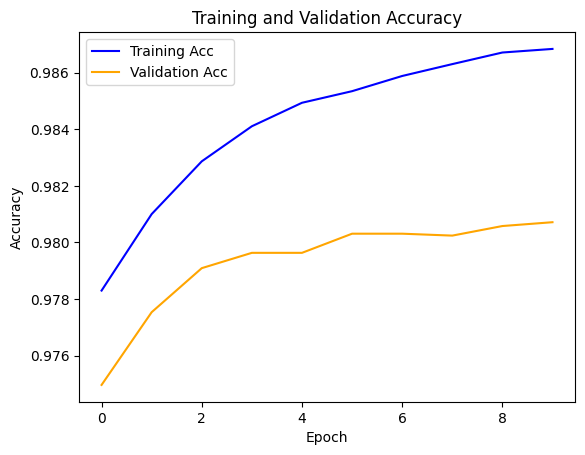

In [56]:
plt.plot(train_acc_list, label='Training Acc', color='blue')
plt.plot(val_acc_list, label='Validation Acc', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

=========================== Validation Data ===========================
Validation Accuracy: 0.9807
Validation Precision: 1.0000
Validation Recall: 1.0000
Validation F1 Score: 1.0000


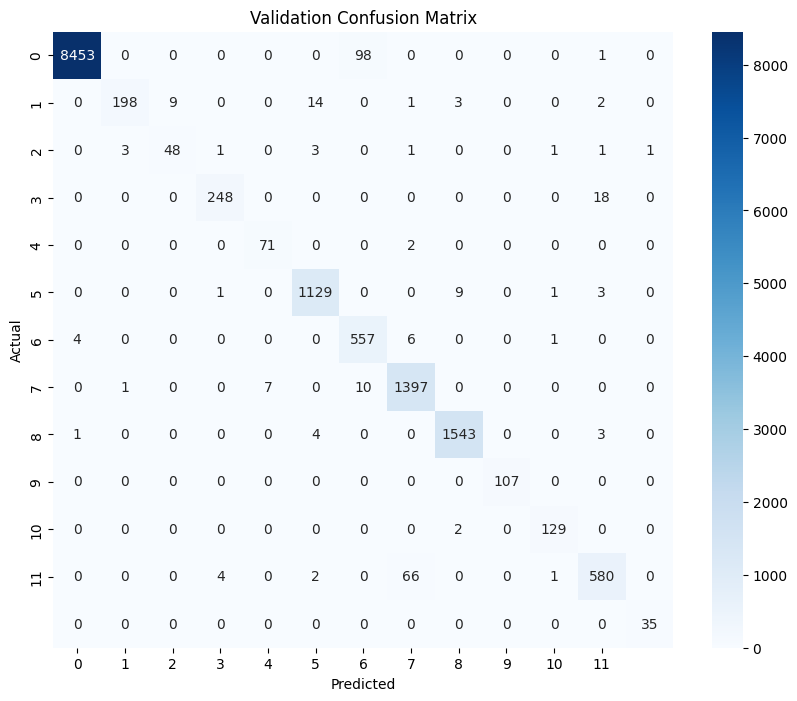

In [57]:
val_acc , val_precision , val_recall, val_f1, val_confusion_matrix = evaluate(model, val_dataloader)

print(f'=========================== Validation Data ===========================')
print(f"Validation Accuracy: {val_accuracy:.4f}")
print(f"Validation Precision: {val_precision:.4f}")
print(f"Validation Recall: {val_recall:.4f}")
print(f"Validation F1 Score: {val_f1:.4f}")
print("=========================================================================")

plt.figure(figsize=(10, 8))
sns.heatmap(val_confusion_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=np.arange(12), yticklabels=np.arange(12))
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Validation Confusion Matrix")
plt.show()

=========================== Test Data ===========================
Test Accuracy: 0.9817
Test Precision: 1.0000
Test Recall: 1.0000
Test F1 Score: 1.0000


<Figure size 800x600 with 0 Axes>

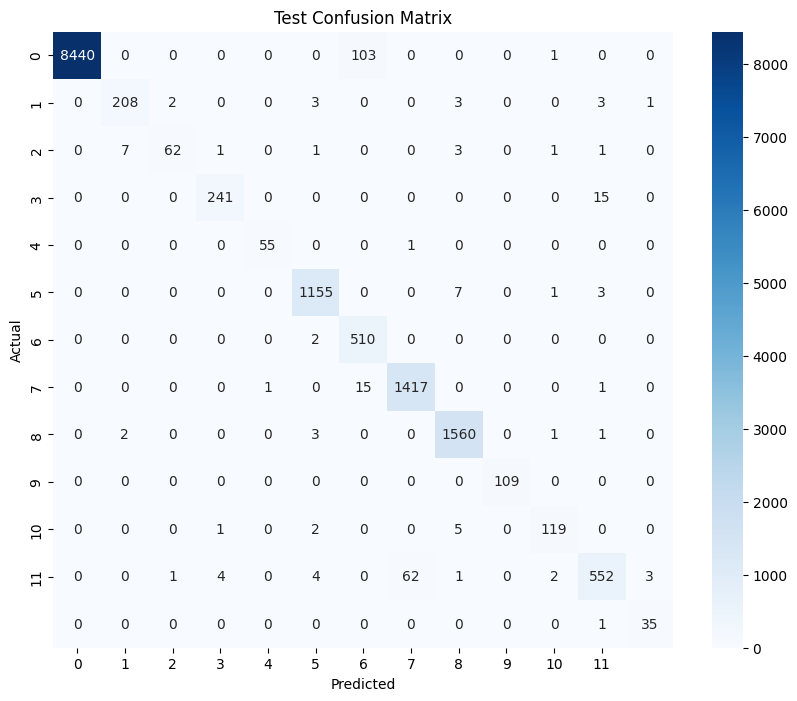

In [58]:
test_accuracy , test_precision , test_recall, test_f1, test_confusion_matrix= evaluate(model, test_dataloader)
print(f'=========================== Test Data ===========================')
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")
print(f"Test F1 Score: {test_f1:.4f}")
print("=========================================================================")

plt.figure(figsize=(8, 6))
plt.figure(figsize=(10, 8))
sns.heatmap(test_confusion_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=np.arange(12), yticklabels=np.arange(12))
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Test Confusion Matrix")
plt.show()

In [59]:
len(word_to_index)

516

In [60]:
len(pos_to_index)

13

In [61]:
torch.save(model.state_dict(), 'rnn.pt')

loaded_model  = LSTMTagger(embedding_dim, hidden_layer_dim, len(word_to_index), len(pos_to_index) , num_layer, bidirectional)
loaded_model.load_state_dict(torch.load('rnn.pt'))
print(loaded_model)


LSTMTagger(
  (word_embeddings): Embedding(516, 200)
  (lstm): LSTM(200, 200)
  (hidden2tag): Linear(in_features=200, out_features=13, bias=True)
)
